# Logistic Regression

Classification problems occur often, perhaps even more so than regression problems. Some examples include:

- Knowing if a tumour is **Malignant** or **Benign**
- Knowing if an online transaction is **Fraudulent** or **Not Fraudulent**
- Knowing if an email is **Spam** or **Not Spam**

A classifier is a machine learning model that separates the **label** into categories or **classes**. In other words, classification models are **supervised** machine learning models which predict a categorical label.

Logistic regression is a linear model but with a nonlinear response. The response is binary, $\{ 0,1 \}$, or positive and negative. The response is the prediction of the category. 


Logistic regression is widely used as a classification model. You can think of this response as having a Binomial distribution. For linear regression the response is simply linear. Logistic regression is a linear regression model with a nonlinear output. The response of the linear model is transformed or 'squashed' to values close to 0 and 1 using a **sigmoidal function**, also known as the **logistic function**. The result of this transformation is a response which is the log likelihood for each of the two classes. 

The sigmoidal or logistic function can be expressed as follows:

$$f(x) = \frac{1}{1 + e^{-\kappa(x) }} \\
\kappa = steepness$$

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 0, 'Value of output from linear regression')

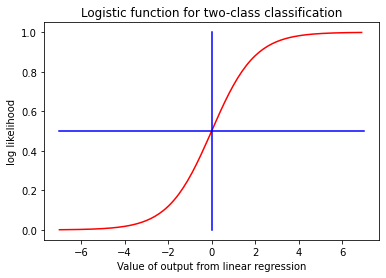

In [2]:
xseq = np.arange(-7, 7, 0.1)

logistic = [math.exp(v)/(1 + math.exp(v)) for v in xseq]

plt.plot(xseq, logistic, color = 'red')
plt.plot([-7,7], [0.5,0.5], color = 'blue')
plt.plot([0,0], [0,1], color = 'blue')
plt.title('Logistic function for two-class classification')
plt.ylabel('log likelihood')
plt.xlabel('Value of output from linear regression')

We will now consider our first logistic regression example. We will work with the same Titanic DataSet from a Kaggle Competition. We have used the dataset before in previous lessons

We'll be trying to predict a classification- survived or deceased for passengers on the ship.We will use this example to understand implemention of Logistic Regression in Python for classification. 

In [2]:
import pandas as pd
import seaborn as sns

## The Data

We will start by reading in the titanic_train.csv file into a pandas dataframe.

In [4]:
titanic_train = pd.read_csv('titanic_train.csv')

In [5]:
titanic_train.head() #The head method is used to preview our imported data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
titanic_train.info() #info method is to check all columns with number of rows and possible missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Exploratory Data Analysis

As always, Exploratory Data Analysis (EDA) is an important step to carry out before modelling. We would carry out some EDA. We can start by checking missing values.

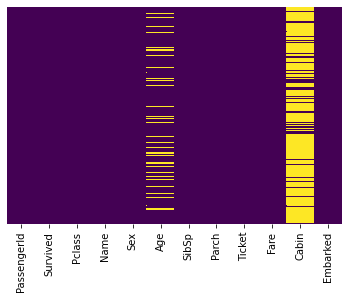

In [7]:
sns.he atmap(titanic_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')##this is to visualize presence of missing values in columns

About 20 percent of the Age data is missing. The proportion of Age missing is still small enough for reasonable replacement with some form of imputation. Looking at the Cabin column however, it looks like we are just missing too much of that data to do something useful with at a basic level. We might have to drop this column as it contains too many holes.

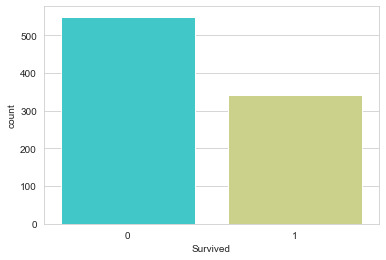

In [8]:
#The code returns the count of the target column 'Survived'

sns.set_style('whitegrid')
sns.countplot(x='Survived',data=titanic_train,palette='rainbow')

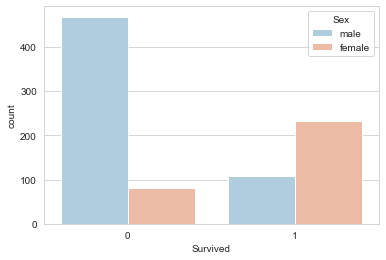

In [10]:
   ## The code plots the count of the Survived column according to the Sex set to hue 

sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=titanic_train,palette='RdBu_r')

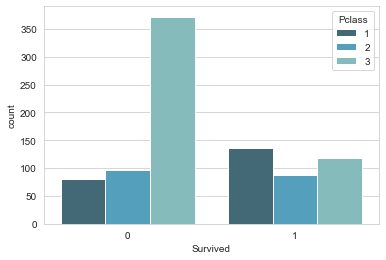

In [11]:
## The code plots the count of the survived column according to the passenger class set to hue

sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=titanic_train,palette='GnBu_d')

We can check the distribution of the age column by using distplot

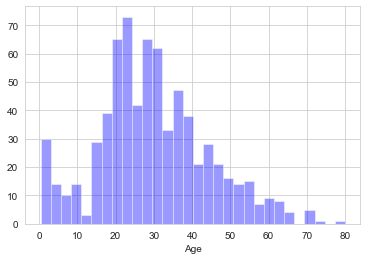

In [12]:
sns.distplot(titanic_train['Age'].dropna(),kde=False,color='blue',bins=30)

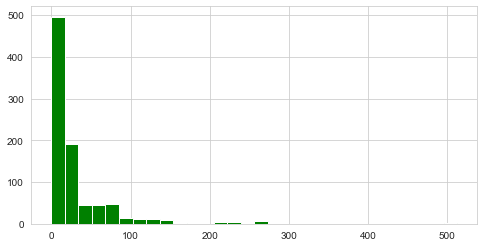

In [13]:
## The code plots the histogram of the distribution of fare paid by passengers
titanic_train['Fare'].hist(color='green',bins=30,figsize=(8,4))

### Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. We can do this by filling in the mean age of all the passengers (mean imputation).
However, a smarter way to do this might be to impute the average age by passenger class. Let us first see if different passenger classes have different age distribution.


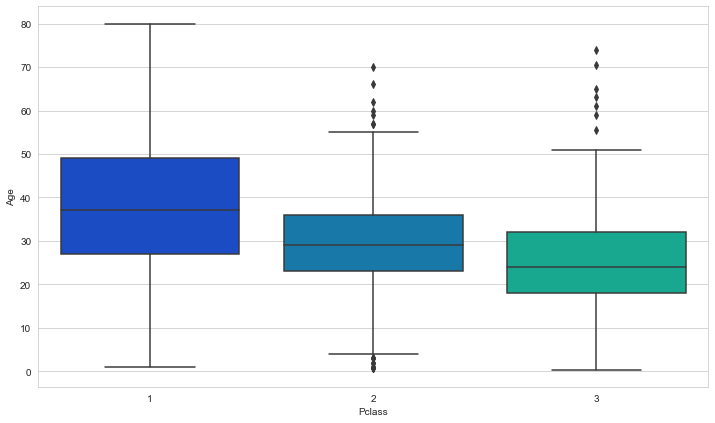

In [14]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=titanic_train,palette='winter')

The plot shows that 1st class passengers who tend to be richer also tend to be older. This makes sense so we would impute mean of age according to passenger class in rows with missing ages

In [15]:
titanic_train.groupby(['Pclass'])['Age'].mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

We will now define a function that inputs the mean age of each passenger class in place of missing values

In [16]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 38

        elif Pclass == 2:
            return 30

        else:
            return 25

    else:
        return Age

In [17]:
## The code utilizes the function above by calling it
titanic_train['Age'] = titanic_train[['Age','Pclass']].apply(impute_age,axis=1)

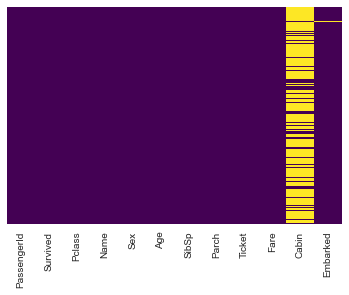

In [18]:
## we will check the heatmap again to make sure we have dealt with all missing values in Ages
sns.heatmap(titanic_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

We will go ahead and drop column Cabin and any row with missing values

In [19]:
titanic_train.drop('Cabin',axis=1,inplace=True)

In [20]:
titanic_train.dropna(inplace=True)

### Converting Categorical Features 

We need to convert categorical features to numeric features otherwise our machine learning algorithm won't be able to directly accept those features as inputs. We can easily do this by using dummy variables

In [21]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [22]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [23]:
## The code uses pandas get_dummies method to create dummy variables
sex = pd.get_dummies(titanic_train['Sex'],drop_first=True) 
embark = pd.get_dummies(titanic_train['Embarked'],drop_first=True)

In [24]:
titanic_train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [25]:
## we will combine th columns left in our training data with the new columns sex and embarked containing dummy variables
titanic_train= pd.concat([titanic_train,sex,embark],axis=1)

In [26]:
titanic_train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


Now our data is in a ready form for the logistic regression algprithm

## Logistic Regression Model

We have to start by splitting our training data into training set and validating/testing set.

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(titanic_train.drop('Survived',axis=1), 
                                                    titanic_train['Survived'], test_size=0.30, 
                                                    random_state=101)

In [29]:
## We will import the logistic regression model from scikit_learn module
from sklearn.linear_model import LogisticRegression

In [30]:
# The code is to create an instance of the logistic regressor and fit it to our data
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [31]:
predictions = logreg.predict(X_test)

## Evaluation

For classifiers there are a number of metrics commonly used. The **confusion matrix** lays out the correctly and incorrectly classified cases in a tabular format. There are various metrics derived from the values in the confusion matrix. Some of the common ones are below. 

**Confusion matrix**

As already stated, the confusion matrix lays out correctly and incorrectly classified cases. For the binary (two-class) case the confusion matrix is organized as follows:

| | Scored Positive | Scored Negative|  
|------|:------:|:------:| 
|**Actual Positive** | True Positive | False Negative |
|**Actual Negative**| False Positive | True Negative |   

Here the four elements in the matrix are defined as:    
**True Positive** or **TP** are cases with positive labels which have been correctly classified as positive.     
**True Negative** or **TN** are cases with negative labels which have been correctly classified as negative.  
**False Positive** or **FP** are cases with negative labels which have been incorrectly classified as positive.   
**False Negative** or **FN** are cases with positive labels which have been incorrectly classified as negative.

When creating a confusion matrix it is important to understand and maintain a convention for which differentiating positive and negative label values. The usual convention is to call the $1$ case positive and the $0$ case negative. 

Notice that there is an ambiguity in which case is considered positive and which is considered negative when the confusion matrix is computed. Whenever you examine a confusion matrix it is a good idea to spend a moment and decide which case is which. This step will help you relate the results to the problem at hand. 

**Accuracy**

Accuracy is a simple and often misused metric. In simple terms, accuracy is the fraction of cases correctly classified. For a two-class classifier accuracy is written as:

$$Accuracy = \frac{TP+TN}{TP+FP+TN+FN}$$

Accuracy can be quite misleading. For example, say a classifier is used to detect fraudulent accounts and the rate of fraud is less than 1%. A naive model would be to say all accounts are not fraudulent. This model has accuracy exceeding  0.99. This sounds impressive, but is clearly useless. 

**Precision**

Precision is the fraction of correctly classified label cases out of all cases classified with that label value. We can express precision by the following relationship:

$$Precision = \frac{M_{i,i}}{\sum_j M_{i,j}}$$

In other words, the precision statistic is the number of correctly classified cases for the label value divided by all the cases in the column. Thus, precision is sensitive to the number of cases correctly classified for a given score value. 

**Recall**  

Recall is the fraction of cases of a label value correctly classified out of all cases that actually have that label value. We can express recall by the following relationship:

$$Recall = \frac{M_{i,i}}{\sum_i M_{i,j}}$$

In other words, the recall statistic is the number of correctly classified cases for the label value divided by all the cases in the row. Thus, recall is sensitive to the number of cases correctly classified for a given true label value. 

**F1**

The F1 statistic is weighted average of precision and recall. We can express F1 by the following relationship:

$$F1 = 2 * \frac{precision * recall}{precision + recall}$$

In other words, F1 is a weighted metric for overall model performance. 

**ROC** and **AUC**

The receiver operating characteristic or ROC is a curve that displays the relationship between the true positive rate on the vertical axis and false positive rate on the horizontal axis. The ROC curve shows the tradeoff between true positive rate and false positive rate. An example is illustrated below.   

In principle, you can pick the desired operating point for a classifier on this curve. Towards the left favors low false positive rate at the expense of true positive rate. Towards the right favors high true positive rate at the expense of higher false positive rate. 

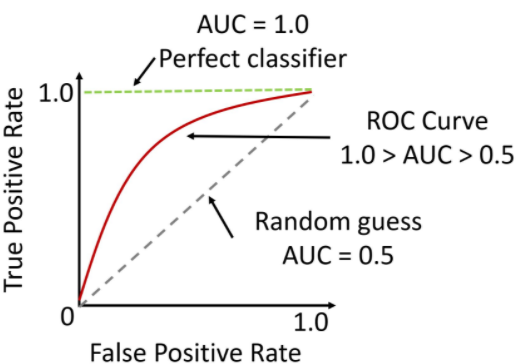

The AUC is the area or integral under the ROC curve. The overall performance of the classifier is measured by the area under the curve or AUC. But, how can you interpret a specific AUC value? The higher the AUC the lower the increase in false positive rate required to achieve a required true positive rate.  For an ideal classifier the AUC is 1.0. A true positive rate is achieved with a 0 false positive rate. This behavior means that AUC is useful for comparing classifiers. The classifier with higher AUC is generally the better one. 

For balanced cases, random guessing gives an AUC or 0.5. A balanced case has equal numbers of positive and negative cases. So Bernoulli sampling (random guessing) with a probability $p$ for the positive case, will produce a ROC curve that runs diagonally from $0.0,0.0$ to $1.0,1.0$. The area under this triangular region is 0.5. It is often said that a classifier with an AUC of greater than 0.5 is better than random guessing.

We can check the precision, recall and F-1 score from sklearn classification report

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       163
           1       0.81      0.63      0.71       104

    accuracy                           0.80       267
   macro avg       0.81      0.77      0.78       267
weighted avg       0.80      0.80      0.80       267



In [33]:
import sklearn.metrics as sklm

In [34]:
#We would define a function to print out the confusion matrix and other metric with the necessary formatting

def print_metrics(labels, predictions):
    metrics = sklm.precision_recall_fscore_support(labels, predictions)
    conf = sklm.confusion_matrix(labels, predictions)
    print('                 Confusion matrix')
    print('                 Score Negative    Score Positive')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, predictions))
    print(' ')
    print('           Negative      Positive')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])


    
print_metrics(y_test, predictions)

                 Confusion matrix
                 Actual Negative    Actual Positive
Score positive       148                15
Score negative        38                66

Accuracy  0.80
 
           Negative      Positive
Num case      163           104
Precision    0.80          0.81
Recall       0.91          0.63
F1           0.85          0.71


Our result seems to be fairly good, outperforming random guessing.

# Example 2

In this example, we will be attempting to predict if a bank customer will default on their loans or not using the bank's credit data.

In [6]:
credit = pd.read_csv('German_Credit_Preped.csv')
print(credit.shape)
credit.head(3)

(1000, 22)


,customer_id,checking_account_status,loan_duration_mo,credit_history,purpose,loan_amount,savings_account_balance,time_employed_yrs,payment_pcnt_income,gender_status,...,property,age_yrs,other_credit_outstanding,home_ownership,number_loans,job_category,dependents,telephone,foreign_worker,bad_credit
0,1122334,< 0 DM,6,critical account - other non-bank loans,radio/television,1169,unknown/none,>= 7 years,4,male-single,...,real estate,67,none,own,2,skilled,1,yes,yes,0
1,6156361,0 - 200 DM,48,current loans paid,radio/television,5951,< 100 DM,1 - 4 years,2,female-divorced/separated/married,...,real estate,22,none,own,1,skilled,1,none,yes,1
2,2051359,none,12,critical account - other non-bank loans,education,2096,< 100 DM,4 - 7 years,2,male-single,...,real estate,49,none,own,1,unskilled-resident,2,none,yes,0


There are 22 columns, 1 customer identifier column, 20 features, plus a label column. These features represent information a bank might have on its customers.

There is one other aspect of this data set which we have to be careful of. The label has significant **class imbalance**. Class imbalance means that there are  unequal numbers of cases for the categories of the label. 

To examine the class imbalance in these data, we will execute the code in the cell below.

In [4]:
credit_counts = credit[['credit_history', 'bad_credit']].groupby('bad_credit').count()
print(credit_counts)

            credit_history
bad_credit                
0                      700
1                      300


Notice that only 30% of the cases have bad credit. This is not surprising, since a bank would typically retain customers with good credit. However, this imbalance will bias the training of any model.

### Data Preparation

As part of the data preparation for modelling, we have to create the numpy arrays required for the scikit-learn model. 

The code in the cell below creates a numpy array of the label values.

In [38]:
labels = np.array(credit['bad_credit'])
print(labels)

[0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0
 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0 0 0 1 1 1
 0 1 0 1 0 1 0 1 1 1 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0
 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 1 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 

Now, we need to create the numpy feature array or **model matrix**. As first step, the categorical variables need to be recoded as binary dummy variables. We have to carry out three steps to do this:

1. Encode the categorical string variables as integers.
2. Transform the integer coded variables to dummy variables. 
3. Append each dummy coded categorical variable to the model matrix. 

We will define a function in the cell below to perform this processing

In [39]:
from sklearn import preprocessing

In [40]:
def encode_string(cat_features):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_features)
    enc_cat_features = enc.transform(cat_features)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_features.reshape(-1,1))
    return encoded.transform(enc_cat_features.reshape(-1,1)).toarray()

categorical_columns = ['credit_history', 'purpose', 'gender_status', 
                       'time_in_residence', 'property']

Features = encode_string(credit['checking_account_status'])
for col in categorical_columns:
    temp = encode_string(credit[col])
    Features = np.concatenate([Features, temp], axis = 1)

print(Features.shape)
print(Features[:2, :]) 

(1000, 31)
[[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 0.]]


Next we would concatenate numeric features and the numpy array

In [41]:
Features = np.concatenate([Features, np.array(credit[['loan_duration_mo', 'loan_amount', 
                            'payment_pcnt_income', 'age_yrs']])], axis = 1)
print(Features.shape)
print(Features[:2, :]) 

(1000, 35)
[[0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 6.000e+00 1.169e+03 4.000e+00 6.700e+01]
 [1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 1.000e+00 0.000e+00 4.800e+01 5.951e+03 2.000e+00 2.200e+01]]


With the dummy variables the original 6 categorical features are now 31 dummy variables. With the 4 numeric features there are a total of 35.
Next we must split the cases into training and test data sets. This step is critical. If machine learning models are tested on the training data, the results will be both biased and too optimistic.

In [42]:
import sklearn.model_selection as ms

In [43]:
## The code will randomly sample cases to create independent training and test data
np.random.seed(9988)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 300)
X_train = Features[indx[0],:]
y_train = np.ravel(labels[indx[0]])
X_test = Features[indx[1],:]
y_test = np.ravel(labels[indx[1]])

There is just one more step in preparing this data. Numeric features must be rescaled so they have a similar range of values. Rescaling prevents features from having an undue influence on model training simply because then have a larger range of numeric variables.

The code in the cell below uses the StandardScaler function from the Scikit Learn preprocessing package to Zscore scale the numeric features. Notice that the scaler is fit only on the training data. The trained scaler is these applied to the test data. Test data should always be scaled using the parameters from the training data.

In [45]:
scaler = preprocessing.StandardScaler().fit(X_train[:,31:])
X_train[:,31:] = scaler.transform(X_train[:,31:])
X_test[:,31:] = scaler.transform(X_test[:,31:])
X_train[:2,]

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  1.53154035,  0.62707145, -0.86525095, -0.93382362],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.27037074,  1.65067659, -1.

### The logistic regression model

Now we need to construct the logistic regression model

In [47]:
from sklearn import linear_model

In [48]:
logistic_model = linear_model.LogisticRegression() 
logistic_model.fit(X_train, y_train)

LogisticRegression()

We can print out the model coefficients and intercept just like with a linear regression model

In [49]:
print(logistic_model.intercept_)
print(logistic_model.coef_)

[-0.55913985]
[[ 0.19846303  0.93617114 -0.11259824 -1.02222806  0.53330439 -0.96441822
  -0.25740363  0.91100636 -0.22268102  0.06356988  0.62419289 -0.51091859
   0.29118816  0.27810232  0.14503389 -0.44298374 -0.28398756  0.19639902
  -0.36078838  0.08146493  0.23727233  0.09724962 -0.41617901 -0.36638268
   0.40725783 -0.17863148  0.13756422 -0.07780448  0.09474882 -0.33716583
   0.32002937  0.27237073  0.18088435  0.25423605 -0.18171383]]


We can notice that model coefficients look just as they would for an regression model. Also,all the coefficients have the same magnitude indicating this model is likely to be overfit, given the number of features.

Since the logistic regression model outputs probabilities for each class. The class with the highest probability is taken as the score (prediction). The code in the cell below computes and displays a sample of these class probabilities for the test feature set.

In [50]:
probabilities = logistic_model.predict_proba(X_test)
print(probabilities[:15,:])

[[0.84681629 0.15318371]
 [0.40257297 0.59742703]
 [0.94359534 0.05640466]
 [0.31580645 0.68419355]
 [0.55073035 0.44926965]
 [0.97548673 0.02451327]
 [0.94935223 0.05064777]
 [0.62315898 0.37684102]
 [0.87530439 0.12469561]
 [0.9271592  0.0728408 ]
 [0.56872575 0.43127425]
 [0.40185487 0.59814513]
 [0.50475289 0.49524711]
 [0.67690928 0.32309072]
 [0.35000049 0.64999951]]


### Model evaluation

Now that the class probabilities have been computed these values must be transformed into actual class scores. We can recall that the log likelihoods for two-class logistic regression are computed by applying the sigmoid or logistic transformation to the output of the linear model. The simple choice is to set the threshold between the two likelihoods at $0.5$. The code in the cell below applies this initial threshold to the probability of a score of $0$ for the test data. A few examples along with the known labels are then displayed.

In [51]:
def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])
scores = score_model(probabilities, 0.5)
print(np.array(scores[:15]))
print(y_test[:15])

[0 1 0 1 0 0 0 0 0 0 0 1 0 0 1]
[0 0 0 1 0 0 0 0 1 0 0 1 1 0 1]


Some of the positive ($1$) predictions agree with the test labels in the second row, but several do not.

We can  use the same code we used in example one to display the confusion matrix.

In [52]:
def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('Actual positive    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Actual negative    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('           Positive      Negative')
    print('Num case   %6d' % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])


    
print_metrics(y_test, scores)

                 Confusion matrix
                 Score positive    Score negative
Actual positive       183                29
Actual negative        39                49

Accuracy  0.77
 
           Positive      Negative
Num case      212            88
Precision    0.82          0.63
Recall       0.86          0.56
F1           0.84          0.59


Let us examine these results:
1. The confusion matrix shows the following characteristics; a) most of the positive cases are correctly classified, 182 vs. 30, however, b) may negative cases are are scored incorrectly, with only 49 correct, vs. 39 incorrect.   
2. The overall accuracy is 0.77. However as just observed this is **extremely misleading!**. In fact the negative cases are poorly classified, and it is these bad credit customers the bank cares most about. This is not an unusual case. Accuracy figures should always be regarded with healthy skepticism.
3. The class imbalance is confirmed. Of the 300 test cases 212 are positive and 88 are negative. 
4. The precision, recall and F1 all show that positive cases are classified reasonably well, but the negative cases are not. As already mentioned, it is these negative cases that are of greatest importance to the bank. 

Let us use the code in the cell below computes and displays the ROC curve and AUC. The `roc_curve` and `auc` functions from the scikit-learn `metrics` package are used to compute these values.

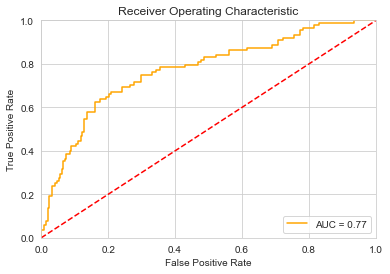

In [53]:
def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
plot_auc(y_test, probabilities) 

### Using a weighted model

In this particular example, falsely classifying a bad credit risk customer as good costs the bank five times more than classifying a good credit risk customer as bad. Given this situation, the results of the first model are not that good. There are two reasons for this:

1. The class imbalance in the label has biased the training of the model. We can almost get the same level of accuracy by guessing that every customer has good credit risk. 
2. Nothing has been done to weight the results toward correctly classifying the bad credit risk customers at the expense of the good credit risk customers.

One approach to these problems is to weight the classes when computing the logistic regression model. The code in the cell below adds a `class_weight` argument to the `LogisticRegression` function. In this case weights are chosen as $0.45, 0.55$  but we can also give another combination.

In [54]:
logistic_model = linear_model.LogisticRegression(class_weight = {0:0.30, 1:0.70}) 
logistic_model.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.3, 1: 0.7})

We can then display the class probability for each case in the data

In [55]:
probabilities = logistic_model.predict_proba(X_test)
print(probabilities[:15,:])

[[0.71047174 0.28952826]
 [0.21425079 0.78574921]
 [0.88470602 0.11529398]
 [0.18894705 0.81105295]
 [0.38319624 0.61680376]
 [0.94365981 0.05634019]
 [0.89770619 0.10229381]
 [0.42434523 0.57565477]
 [0.76969965 0.23030035]
 [0.83296601 0.16703399]
 [0.38171278 0.61828722]
 [0.2385836  0.7614164 ]
 [0.34703335 0.65296665]
 [0.52116226 0.47883774]
 [0.20458219 0.79541781]]


We can find out if there is any significant difference with the unweighted model by computing the scores and the metrics. We will display the metrics by executing the code in the cell below. 


                 Confusion matrix
                 Score positive    Score negative
Actual positive       143                69
Actual negative        21                67

Accuracy  0.70
 
           Positive      Negative
Num case      212            88
Precision    0.87          0.49
Recall       0.67          0.76
F1           0.76          0.60


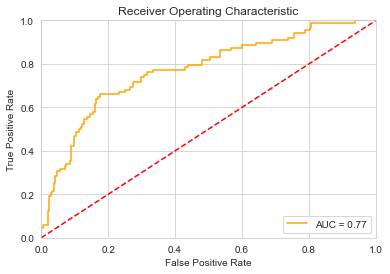

In [56]:
scores = score_model(probabilities, 0.5)
print_metrics(y_test, scores)  
plot_auc(y_test, probabilities)

Here is what we will notice : the accuracy is slightly changed with respect to the unweighted model. The change could be more had we give more weights to one of the class than what we did here. The precision, recall and F1 are slightly better for the negative cases. Reweighting the labels has moved the results in the desired direction, at least a bit.

We can also notice that the ROC curve and AUC are essentially unchanged. The trade-off between true positive and false positive is similar to the unweighted model.

#### Changing thresholds

We can also tip the scale of the model scoring towards successfully identifying bad credit risk customers by changing the model threshold. We would iterate through five possible thresholds in the code cell below.

In [54]:
def test_threshold(probs, labels, threshold):
    scores = score_model(probs, threshold)
    print('')
    print('For threshold = ' + str(threshold))
    print_metrics(labels, scores)

thresholds = [0.45, 0.40, 0.35, 0.3, 0.25]
for t in thresholds:
    test_threshold(probabilities, y_test, t)


For threshold = 0.45
                 Confusion matrix
                 Score positive    Score negative
Actual positive       161                51
Actual negative        30                58

Accuracy  0.73
 
           Positive      Negative
Num case      212            88
Precision    0.84          0.53
Recall       0.76          0.66
F1           0.80          0.59

For threshold = 0.4
                 Confusion matrix
                 Score positive    Score negative
Actual positive       147                65
Actual negative        24                64

Accuracy  0.70
 
           Positive      Negative
Num case      212            88
Precision    0.86          0.50
Recall       0.69          0.73
F1           0.77          0.59

For threshold = 0.35
                 Confusion matrix
                 Score positive    Score negative
Actual positive       139                73
Actual negative        22                66

Accuracy  0.68
 
           Positive      Negative
Num cas

As the threshold is decreased the number of correctly classified negative cases (bad credit customers) increases at the expense of correctly classifying positive cases (good credit customers). At the same time, accuracy decreases. However, as you might have suspected, accuracy is not a particularly useful metric here. 

Exactly which threshold to pick is a business decision. Notice that with a threshold value of 0.25 the number of false negatives (misclassified good credit customers) is about four times that of false positives (misclassified bad credit customers).

## END